## Ноутбук для обучения и валидации модели детекции с использованием префиксов

### Импортируем библотеки

In [353]:
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import re
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, mean_squared_error, precision_score, accuracy_score, recall_score
from tqdm.auto import tqdm
from datasets import load_dataset, load_from_disk
import matplotlib.pyplot as plt

### Фиксируем зависимости

In [355]:
device = 'cuda'
model_path = 'sberbank-ai/ruRoberta-large'
dataset_path = 'shershen/ru_anglicism'
out_dir = 'weights'
prefix_len = 25
linear_lr = 1e-5
prefix_lr = 1e-3
epochs = 5
threshold = 0.8

### Функция для создания ner-маски

In [332]:
def create_mask(full_txts, phrases, max_length=512):
    if isinstance(full_txts, str):
        full_txts = [full_txts]
        phrases = [phrases]
    toks = tokenizer(full_txts, return_offsets_mapping=True,truncation=True,max_length=max_length,padding=True,return_tensors='pt')
    all_maps = []
    phrases = [x.split(', ') for x in phrases]
    for phrase,full_txt, off_map, att_mask in zip(phrases, full_txts,toks['offset_mapping'], toks['attention_mask']):
        local_maps = []
        for k, phr in enumerate(phrase):
            first_end = False
            ner_map = []
            start_point = full_txt.find(phr)
            end_point = start_point + len(phr)
            for s0,e0 in off_map.detach().cpu().numpy():
                if first_end:
                    ner_map.append(-100)
                elif s0!=e0 and s0>=start_point and e0<=end_point:
                    ner_map.append(1)
                elif s0!=e0 and e0>=start_point and e0<=end_point:
                    ner_map.append(1)
                elif s0==e0:
                    ner_map.append(-100)
                elif e0>len(full_txt):
                    ner_map.append(-100)
                    first_end = True
                else:
                    ner_map.append(0)
            if (len(phrase) > 1) and (k+1 == len(phrase)):
                ner_map = (np.array(ner_map) + np.array(local_maps[-1])).tolist()
                ner_map = [-100 if x == -200 else x for x in ner_map]
                ner_map = [1 if x == 2 else x for x in ner_map]
            if k+1 == len(phrase):
                all_maps.append(ner_map)
            else:
                local_maps.append(ner_map)
    return all_maps

### Скачиваем датасет и веса модели

In [333]:
df = load_dataset(dataset_path)
train_df = pd.DataFrame(df['train'])
test_df = pd.DataFrame(df['test'])

No config specified, defaulting to: ru_anglicism/default
Found cached dataset ru_anglicism (/home/jovyan/.cache/huggingface/datasets/shershen___ru_anglicism/default/0.1.0/cf5c584d109a310dfa58dcd48726f1f13d4327267043dfa9c2130e9b02217838)


  0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path).to(device)

Some weights of the model checkpoint at sberbank-ai/ruRoberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at sberbank-ai/ruRoberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to b

In [318]:
train_df.head(10)

,word,form,sentence,paraphrase
0,кринж,кринжовую,Моя подруга рассказала кринжовую историю.,Моя подруга рассказала стыдную историю.
1,кринж,кринж,Я словил кринж после этого ролика.,Я испытал стыд после этого ролика.
2,кринж,кринж,Ситуация полный кринж.,Ситуация полный стыд.
3,"лук, маркетинг","лук, маркетинга",Эта девушка предложила снять новый лук с новой...,Эта девушка предложила снять новый образ с нов...
4,лукбук,лукбуке,"""Розница предусмотрена для тех, у кого нет вре...","""Розница предусмотрена для тех, у кого нет вре..."
5,аутфит,аутфит,"Ее модный аутфит был продуман до мелочей, поэт...","Ее модный образ был продуман до мелочей, поэто..."
6,чекать,чекну,"Кинь ссылку, чекну, вдруг знаю его.","Кинь ссылку, проверю, вдруг знаю его."
7,чекать,чекни,"Если ты не до конца уверен в этой инфе, лучше ...","Если ты не до конца уверен в этой инфе, лучше ..."
8,"чекать, айтишник","чекни, айтишника","Вован, чекни нашего нового айтишника, какой-то...","Вован, проверь нашего нового программиста, как..."
9,хайп,хайп,Вокруг этой темы подняли ужасный хайп.,Вокруг этой темы подняли ужасный шумиху.


In [319]:
test_df.head(10)

,word,form,sentence,paraphrase
0,"юзер, айди","юзер, айди",Для входа в учетную запись юзер должен ввести ...,Для входа в учетную запись пользователь должен...
1,скринить,скринит,Эта дура скринит переписки и постит в инстаграм.,Эта дура фотографирует переписки и выставляет ...
2,вайб,вайб,"Не могу это объяснить, но у четверга и 16:00 о...","Не могу это объяснить, но у четверга и 16:00 о..."
3,вайб,вайб,"""Вчера выпал пушистый снег и в воздухе царил н...","""Вчера выпал пушистый снег и в воздухе царило ..."
4,чек-ап,чекап,Программа чекап в ИНВИТРО создана специально д...,Программа комплексного медицинского обследован...
5,чек-ап,Чек-Ап,"В ЛДЦ ""Кутузовский"" в Москве вы можете пройти ...","В ЛДЦ ""Кутузовский"" в Москве вы можете пройти ..."
6,чек-ап,чек-ап,"Женский и мужской чек-ап, гинекологический чек...",Комплексное медицинское обследование женщин и ...
7,спич,спичем,"""Леди и гамильтоны"", торжественно сказал я сло...","""Леди и гамильтоны"", торжественно сказал я сло..."
8,спич,спич,Вступительный спич с ходу подхватил Денис Грук...,Вступительную речь с ходу подхватил Денис Грук...
9,спич,спича,"Смысл конкретно того спича заключался в том, ч...","Смысл конкретно той речи заключалась в том, чт..."


### Функции для обучения и валидации

In [35]:
def ner_train(clsf_layer, past_key_tensor,df, past_key_lr=1e-3, linear_lr=1e-3, dx=16):
    loss_func = nn.CrossEntropyLoss(torch.tensor([1.,10.])).to(device)
    optimizer = torch.optim.AdamW([
        {'params': past_key_tensor, 'lr': past_key_lr},
        {'params': [x for x in clsf_layer.parameters()], 'lr': linear_lr}
    ])
    losses = []
    print('Training...')
    for pos in tqdm(range(0,len(df),dx)):
        optimizer.zero_grad()
        txt = df['sentence'].values[pos:pos+dx].tolist()
        word = df['form'].values[pos:pos+dx].tolist()
        use_past = [x.repeat_interleave(len(txt),dim=1) for x in past_key_tensor]
        toks = tokenizer(txt, truncation=True, max_length=512-past_key_tensor[0].shape[3],padding=True,return_tensors='pt').to(device)
        att_mask = torch.cat([torch.ones(len(txt),past_key_tensor[0].shape[3]).to(device),
                              toks['attention_mask']],dim=1)
        out = model(toks['input_ids'],attention_mask = att_mask, past_key_values=use_past)['last_hidden_state']
        
        target = torch.tensor(create_mask(txt, word,max_length=512-past_key_tensor[0].shape[3])).to(device)
        out = clsf_layer(out)
        loss = loss_func(out.view(-1,out.size(-1)),target.view(-1))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    return(losses) 

In [264]:
def ner_val(clsf_layer, past_key_tensor,df, threshold=0.8, dx=16):
    loss_func = nn.CrossEntropyLoss(torch.tensor([1.,10.])).to(device)
    losses = []
    precision_ner_score = []
    recall_ner_score = []
    print('Validating...')
    for pos in tqdm(range(0,len(df),dx)):
        txt = df['sentence'].values[pos:pos+dx].tolist()
        word = df['form'].values[pos:pos+dx].tolist()
        use_past = [x.repeat_interleave(len(txt),dim=1) for x in past_key_tensor]
        toks = tokenizer(txt, truncation=True, max_length=512-past_key_tensor[0].shape[3],padding=True,return_tensors='pt').to(device)
        att_mask = torch.cat([torch.ones(len(txt),past_key_tensor[0].shape[3]).to(device),
                              toks['attention_mask']],dim=1)
        out = model(toks['input_ids'],attention_mask = att_mask, past_key_values=use_past)['last_hidden_state']
        
        target = torch.tensor(create_mask(txt, word,max_length=512-past_key_tensor[0].shape[3])).to(device)
        out = clsf_layer(out)
        loss = loss_func(out.view(-1,out.size(-1)),target.view(-1))
        losses.append(loss.item())
        mask = F.softmax(out, dim=-1)[:,:,1]
        mask = torch.where(mask>=threshold, 1, 0)
        target[target==-100] = 0
        precision_ner = precision_score(target.cpu(), mask.cpu(), labels=[1],average='micro', zero_division=0)
        recall_ner = recall_score(target.cpu(), mask.cpu(), labels=[1],average='micro', zero_division=0)
        precision_ner_score.append(precision_ner)
        recall_ner_score.append(recall_ner)
    return(losses, precision_ner_score, recall_ner_score)

### Инициализируем линейный слой и префикс

In [293]:
linear = nn.Linear(1024,2).to(device)
linear.requires_grad = True

In [294]:
train_past = [torch.randn(4,1,16,prefix_len,64).to(device) for _ in range(24)]
for i in train_past:
    i.requires_grad=True

### Класс ранней остановки

In [287]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Обучение

In [295]:
train_losses = []
val_losses = []
early_stopper = EarlyStopper(patience=1)
for i in range(epochs):
    train_loss = ner_train(linear, train_past, train_df.sample(frac=1), prefix_lr, linear_lr, threshold, dx=8)
    with torch.no_grad():
        val_loss, pr_ner_score, r_ner_score = ner_val(linear, train_past, test_df.sample(frac=1), dx=16)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch num: {} \n'.format(i+1),
          'Loss of train: {} \n'.format(np.mean(train_loss)), 
          'Loss of val: {} \n'.format(np.mean(val_loss)),
          'Precision_score_Ner:{} \n'.format(np.mean(pr_ner_score)),
          'Recall_score_Ner:{} \n'.format(np.mean(r_ner_score))
         )
    if early_stopper.early_stop(np.mean(val_loss)):             
        break

Training...


  0%|          | 0/125 [00:00<?, ?it/s]

Validating...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch num: 1 
 Loss of train: 0.3969402457475662 
 Loss of val: 0.25733614961306256 
 Precision_score_Ner:0.3333333333333333 
 Recall_score_Ner:0.3333333333333333 

Training...


  0%|          | 0/125 [00:00<?, ?it/s]

Validating...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch num: 2 
 Loss of train: 0.2409275705218315 
 Loss of val: 0.22348168989022574 
 Precision_score_Ner:0.5 
 Recall_score_Ner:0.3611111111111111 

Training...


  0%|          | 0/125 [00:00<?, ?it/s]

Validating...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch num: 3 
 Loss of train: 0.19916223758459092 
 Loss of val: 0.18646962195634842 
 Precision_score_Ner:0.5833333333333334 
 Recall_score_Ner:0.5555555555555555 

Training...


  0%|          | 0/125 [00:00<?, ?it/s]

Validating...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch num: 4 
 Loss of train: 0.1616629076898098 
 Loss of val: 0.1613892155388991 
 Precision_score_Ner:0.4166666666666667 
 Recall_score_Ner:0.4166666666666667 

Training...


  0%|          | 0/125 [00:00<?, ?it/s]

Validating...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch num: 5 
 Loss of train: 0.13698694767057895 
 Loss of val: 0.15704954291383424 
 Precision_score_Ner:0.5 
 Recall_score_Ner:0.3333333333333333 



### Рисунок лосса

In [349]:
def draw_result(lst_iter, train_loss, val_loss, title):
    plt.plot(train_loss, '-b', label='train loss')
    plt.plot(val_loss, '-r', label='val loss')

    plt.xlabel('n epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper left')
    plt.title(title)

    plt.show()

In [350]:
draw_train = [np.mean(x) for x in train_losses]
draw_test = [np.mean(x) for x in val_losses]

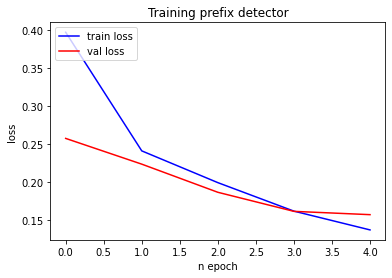

In [351]:
draw_result(epochs, draw_train, draw_test, 'Training prefix detector')

### Посмотрим на одно предсказание

In [309]:
pos = 10
text = test_df['sentence'].values[pos]
phr = test_df['form'].values[pos]
print('Текст: \n' + text)
print('Англицизм: \n' + phr)
toks = tokenizer(text, 
                 padding=True,
                 max_length = 512-train_past[0].shape[3],
                 truncation=True,
                 return_tensors='pt').to(device)
inp_ids = toks['input_ids']
att_mask = torch.cat([torch.ones(1,train_past[0].shape[3]).to(device),
                     toks['attention_mask']
                     ],dim=1)

Текст: 
Игорь не знал, чем ответить на такой пространный спич и неопределенно похмыкал, делая вид, что понимает, о чем говорит Игорь Васильевич.
Англицизм: 
спич


In [310]:
with torch.no_grad():
    out = model(input_ids = inp_ids, attention_mask=att_mask, past_key_values=train_past)
    lin_out = linear(out['last_hidden_state'])
mask = F.softmax(lin_out,dim=-1)[:,:,1]
mask = torch.where(mask>=threshold, 1, 0)
print('Предсказание модели: \n' + tokenizer.decode((inp_ids*mask)[0], skip_special_tokens=True).strip())

Предсказание модели: 
спич


### Функция получения предсказаний, используем батч 1 для нормального вычисления метрик

In [311]:
def get_preds(clsf_layer, past_key_tensor,df, threshold=0.8, dx=1):
    f1_scores = []
    precision_scores = []
    recall_scores = []
    preds = []
    for pos in tqdm(range(0,len(df),dx)):
        txt = df['sentence'].values[pos:pos+dx].tolist()
        word = df['form'].values[pos:pos+dx].tolist()
        use_past = [x.repeat_interleave(len(txt),dim=1) for x in past_key_tensor]
        toks = tokenizer(txt, truncation=True, max_length=512-past_key_tensor[0].shape[3],padding=True,return_tensors='pt').to(device)
        att_mask = torch.cat([torch.ones(len(txt),past_key_tensor[0].shape[3]).to(device),
                              toks['attention_mask']],dim=1)
        out = model(toks['input_ids'],attention_mask = att_mask, past_key_values=use_past)['last_hidden_state']
        target = torch.tensor(create_mask(txt, word,max_length=512-past_key_tensor[0].shape[3])).to(device)
        out = clsf_layer(out)
        mask = F.softmax(out, dim=-1)[:,:,1]
        mask = torch.where(mask>=threshold, 1, 0)
        target[target==-100] = 0
        precision_ner = precision_score(target.cpu().numpy().tolist()[0], mask.cpu().numpy().tolist()[0], labels=[1], average='binary', zero_division=0)
        recall_ner = recall_score(target.cpu().numpy().tolist()[0], mask.cpu().numpy().tolist()[0], labels=[1], average='binary', zero_division=0)
        f1_ner = f1_score(target.cpu().numpy().tolist()[0], mask.cpu().numpy().tolist()[0], labels=[1],average='binary', zero_division=0)
        precision_scores.append(precision_ner)
        recall_scores.append(recall_ner)
        f1_scores.append(f1_ner)
        pr = [tokenizer.decode(x, skip_special_tokens=True).strip() for x in toks['input_ids']*mask]
        preds.extend(pr)
    return(f1_scores, precision_scores, recall_scores, preds)

In [324]:
f1_val, precision_val, recall_val, preds = get_preds(linear, train_past, test_df, threshold=threshold, dx=1)

  0%|          | 0/85 [00:00<?, ?it/s]

In [325]:
print('Final F1: \n{}'.format(np.mean(f1_val)))
print('Final precision: \n{}'.format(np.mean(precision_val)))
print('Final recall: \n{}'.format(np.mean(recall_val)))

Final F1: 
0.8428133957545724
Final precision: 
0.8468737798149562
Final recall: 
0.8693277310924369


In [326]:
pred_df = test_df.copy()
pred_df['preds'] = preds

In [330]:
pred_df.sample(10)

,word,form,sentence,paraphrase,preds
68,"спичрайтер, спикер","спичрайтера, спикера",На третьем (консалтинговом) этапе в задачу спи...,На третьем (консультационном) этапе в задачу с...,алтинговом спичрайтера
20,мэтчиться,мэтчиться,"Каждый эскиз полностью индивидуален, я придерж...","Каждый эскиз полностью индивидуален, я придерж...",мэтч
62,клиффхэнгер,"""клиффхэнгер""","С детьми постарше, которым пора бы уже научить...","С детьми постарше, которым пора бы уже научить...","""клиффхэнгер"
34,"репост, лайк","лайк, репост","Следует отметить, что лайк или репост какого-л...","Следует отметить, что одобрение или пересылка ...",лайк репост
82,амбассадор,амбассадором,Футболист Лионель Месси является амбассадором ...,Футболист Лионель Месси является представителе...,амбассадором
49,юзер,юзеров,"Ссылки, языком юзеров выражаясь, нерабочие.","Ссылки, языком пользователей выражаясь, нерабо...",юзеров
3,вайб,вайб,"""Вчера выпал пушистый снег и в воздухе царил н...","""Вчера выпал пушистый снег и в воздухе царило ...",вайб
23,фаниться,"фаниться, пати","Я не люблю играть в одиночку, мне нравиться фа...","Я не люблю играть в одиночку, мне нравится раз...",фаниться пати
65,голкипер,Голкипер,Голкипер сборной Бельгии и мадридского «Реала»...,Вратарь сборной Бельгии и мадридского «Реала» ...,Гол
66,спичрайтер,спичрайтеров,"Пишут, что Фадеев входил в число сталинских сп...","Пишут, что Фадеев входил в число составителей ...",спичрайтеров


### Сохраняем веса

In [334]:
torch.save(train_past, os.path.join(out_dir, 'adapt_angls.pth'))
torch.save(linear.state_dict(), os.path.join(out_dir, 'lin_angls.pth'))

Результат обучения получился очень хорошим, если учесть сравнительно небольшое количество данных и обучение только префиксов. Финальный результат f1 score - 0.84, что можно считать вполне успешным, поскольку в тестовой выборке нет ни одного англицизма из тренировочной выборки, можно сделать вывод, что модель довольно хорошо обобщила знания.